In the previous notebook (***NLP fundamentals in TensorFlow***), we went through some fundamental natural language processing concepts. The main ones being **tokenization** (turning words into numbers) and **creating embeddings** (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specifically, we're going to be replicating the deep learning model behind the 2017 paper [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*

# The explanation about the project

## Model Input

For example, can we train an NLP model which takes the following input (**Note:** the following sample has had all numerical symbols replaced with "@"):

> To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ). A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale ( @-@ mm ).
Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ).,
Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured.
There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks. The mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively. Further , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group. These differences remained significant at @ weeks. The Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ). Low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ).

## Model output

And returns the following output:

```
['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',
 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',
 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',
 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',
 'RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']
 ```

## Problem in a sentence

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

## Solution in a sentence

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc)  to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

> 📖 **Resources:** Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:
1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

# What we're going to cover

Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

# Hybrid token embedding layer

The hybrid token embedding layer takes a token
as an input and outputs its vector representation
utilizing both the token embeddings and as well as
the character embeddings.

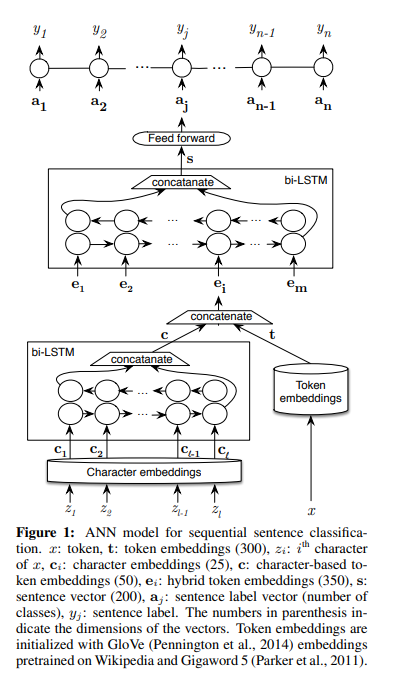

## Definição pelo Gemini

***Em que consiste um Hybrid Token Embedding Layer?***

Imagine que estamos a tentar ensinar um computador a entender a linguagem humana. Uma das primeiras tarefas é transformar as palavras em algo que o computador possa processar: **números**. Mas não qualquer tipo de número, e sim números que capturem o significado e o contexto de cada palavra. Esses números são chamados de **embeddings**.

Um **Hybrid Token Embedding Layer** é uma técnica que combina diferentes tipos de embeddings para criar representações ainda mais ricas e informativas das palavras. É como adicionar mais camadas de significado a cada palavra, permitindo que o modelo de linguagem aprenda relações mais complexas e nuances entre as palavras.

***Por que usar um Hybrid Token Embedding Layer?***

* **Captura de múltiplas facetas do significado:** Ao combinar diferentes tipos de embeddings, o modelo pode capturar aspectos semânticos, sintáticos e até mesmo de domínio específico das palavras.
* **Melhora na generalização:** Modelos que utilizam embeddings híbridos tendem a generalizar melhor para novos dados e a serem mais robustos a variações na linguagem.
* **Desempenho superior em tarefas complexas:** Em tarefas como tradução automática, resumo de texto e geração de texto, os embeddings híbridos podem levar a resultados significativamente melhores.

***Quais tipos de embeddings podem ser combinados?***

Existem diversos tipos de embeddings que podem ser combinados em um layer híbrido, incluindo:

* **Word2Vec:** Embeddings baseados em co-ocorrência de palavras em um grande corpus de texto.
* **GloVe:** Embeddings que combinam estatísticas de contagem e relações logarítmicas entre palavras.
* **BERT:** Embeddings baseados em um modelo de linguagem pré-treinado que leva em conta o contexto de cada palavra.
* **FastText:** Embeddings que representam palavras como a soma dos embeddings de seus caracteres, o que é útil para lidar com palavras desconhecidas.
* **Embeddings específicos de domínio:** Embeddings treinados em um corpus de texto de um domínio específico, como medicina ou direito.

***Como funciona um Hybrid Token Embedding Layer na prática?***

1. **Tokenização:** O texto é dividido em tokens (palavras ou sub-palavras).
2. **Obtenção dos embeddings:** Para cada token, são obtidos os embeddings de cada tipo que será utilizado no layer híbrido.
3. **Combinação dos embeddings:** Os embeddings são combinados de diferentes formas, como concatenação, soma ponderada ou aprendizado de uma matriz de transformação.
4. **Utilização em um modelo de deep learning:** Os embeddings híbridos são utilizados como entrada para um modelo de deep learning, como uma rede neural recorrente ou uma rede neural convolucional.

**Em resumo**, um **Hybrid Token Embedding Layer** é uma ferramenta poderosa para aprimorar a representação de palavras em modelos de linguagem natural, permitindo que eles aprendam relações mais complexas e nuances entre as palavras e obtenham melhores resultados em diversas tarefas.

# Import statements

In [1]:
import os
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow_hub as hub
import string

# Helper Function

Let's get our `helper_functions.py` script we've been using to store helper functions we've created in previous notebooks.

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/CarlosBIOS/TensorFlow/refs/heads/main/helper_functions.py

--2024-11-25 10:11:57--  https://raw.githubusercontent.com/CarlosBIOS/TensorFlow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10364 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.12K  --.-KB/s    in 0s      

2024-11-25 10:11:57 (63.3 MB/s) - ‘helper_functions.py’ saved [10364/10364]



In [3]:
from helper_functions import calculate_results

# Get data

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

We can copy them to our local directory using `git clone https://github.com/Franck-Dernoncourt/pubmed-rct`.

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 46.67 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Checking the contents of the downloaded repository, you can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the [README file](https://github.com/Franck-Dernoncourt/pubmed-rct) from the GitHub page, we get the following information:
* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress `train.7z`, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with `@` but we didn't.

Let's check the file contents.

In [5]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:
* `train.txt` - training samples.
* `dev.txt` - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* `test.txt` - test samples.

To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [6]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
# Check all of the filenames in the target directory
# import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocess data

Okay, now we've downloaded some text data, do you think we're ready to model it?

Wait...

We've downloaded the data but we haven't even looked at it yet.

What's the motto for getting familiar with any new dataset?

I'll give you a clue, the word begins with "v" and we say it three times.

> Vibe, vibe, vibe?

Sort of... we've definitely got to the feel the vibe of our data.

> Values, values, values?

Right again, we want to *see* lots of values but not quite what we're looking for.

> Visualize, visualize, visualize?

Boom! That's it. To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [8]:
# Create function to read the lines of a document
def get_lines(filename: str) -> list:
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, encoding='utf-8') as f:
    return f.readlines()

In [9]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines), len([word for word in train_lines if word.startswith('###')])

(210040, 15000)

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (`\t`) and each sentence finishes with a new line (`\n`).

Different abstracts are separated by abstract ID's (lines beginning with `###`) and newlines (`\n`).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:
* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:  
  * If the line begins with `###` mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n` mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the `\t` as the label of the line.
  * Record the text after the `\t` as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * `"line_number"` - the position of the line in the abstract (e.g. `3`).
  * `"target"` - the role of the line in the abstract (e.g. `OBJECTIVE`).
  * `"text"` - the text of the line in the abstract.
  * `"total_lines"` - the total lines in an abstract sample (e.g. `14`).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [11]:
def preprocess_text_with_line_numbers(filename: str) -> list[dict]:
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines: list = get_lines(filename)
  abstract_lines: str = "" # create an empty abstract
  abstract_samples: list = [] # create an empty list of abstracts
  for line in input_lines:
    if line.startswith('###'):
      abstract_lines = "" # reset abstract string
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data: dict = {} # create empty dict to store data from line
        target_text_split: list = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].casefold() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
        abstract_lines += line

  return abstract_samples

In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 362 ms, sys: 96.2 ms, total: 458 ms
Wall time: 458 ms


(180040, 30212, 30135)

In [13]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Fantastic! Looks like our `preprocess_text_with_line_numbers()` function worked great.

How about we turn our list of dictionaries into pandas DataFrame's so we visualize them better?

In [14]:
# import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


Looks like sentences with the OBJECTIVE label are the least common.

How about we check the distribution of our abstract lengths?

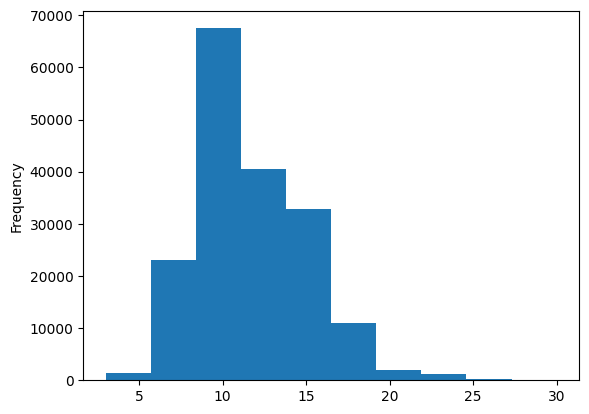

In [16]:
train_df.total_lines.plot.hist();

Okay, looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

# Get lists of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the `tolist()` method on our `"text"` columns.

In [17]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels (ML models require numeric labels)

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.

In [19]:
# One hot encode labels
# from sklearn.preprocessing import OneHotEncoder
# BUT I CAN USE tf.one_hot()
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))  # Como antes usei fit, agora não é preciso
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Label encode labels

In [20]:
# Extract labels ("target" columns) and encode them into integers
# from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

Now we've trained an instance of `LabelEncoder`, we can get the class names and number of classes using the `classes_` attribute.

In [21]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Creating a series of model experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

For each model, we'll train it on the training data and evaluate it on the validation data.

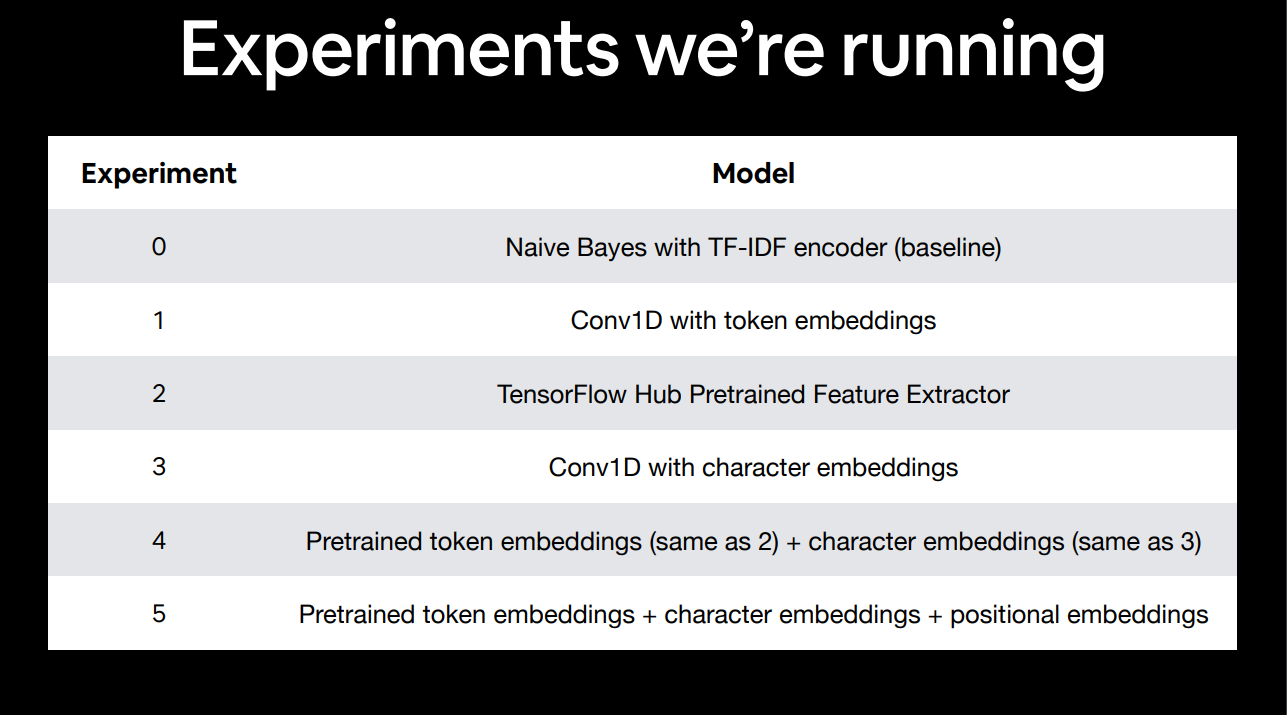

# Model 0: Getting a baseline

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/machine_learning_map.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [22]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

Due to the speed of the Multinomial Naive Bayes algorithm, it trains very quickly.

We can evaluate our model's accuracy on the validation dataset using the `score()` method.

In [23]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Nice! Looks like 72.2% accuracy will be the number to beat with our deeper models.

Now let's make some predictions with our baseline model to further evaluate it.

In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the `calculate_results()` function we created in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb) and added it to our [`helper_functions.py` script](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) to compare them to the ground truth labels.

More specificially the `calculate_results()` function will help us obtain the following:
* Accuracy
* Precision
* Recall
* F1-score

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing our data for deep sequence models

Excellent! We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

Let's write some code to find the average length of sentences in the training set.

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

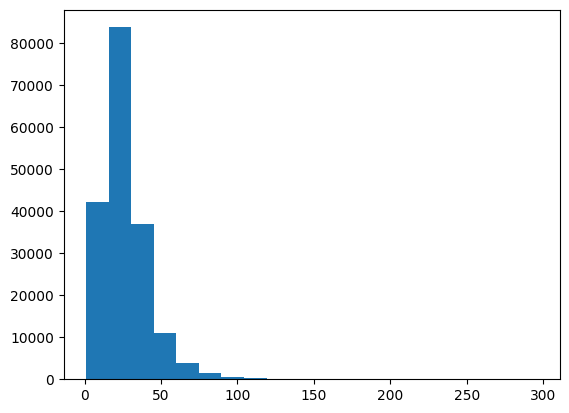

In [27]:
# What's the distribution look like?
# import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [28]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

> 🤔 **Question:** Why 95%?

We could use the max sentence length of the sentences in the training set.

In [29]:
# Maximum sentence length in the training set
max(sent_lens)

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

> 🔑 **Note:** The steps we've gone through are good practice when working with a text corpus for a NLP problem. You want to know how long your samples are and what the distribution of them is. See section 4 Data Analysis of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) for further examples.

# Create text vectorizer

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

In [30]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=68000,
                                                    output_sequence_length=output_seq_len)

In [31]:
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer
# import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the participants received galantamine ( n = @ ; target dose : @ mg ) or risperidone ( n = @ ; target dose : @ mg ) for @ weeks .

Length of text: 32

Vectorized text:
[[    2    60    80 23075    40   492   131    68    16  3329    40   492
    131    68    11    53     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Cool, we've now got a way to turn our sequences into numbers.

> 🛠 **Exercise:** Try running the cell above a dozen or so times. What do you notice about sequences with a length less than 55?

Using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) method of our `text_vectorizer` we can find out a few different tidbits about our text.

In [33]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Create custom text embedding

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

Let's see it in action.

In [35]:
tf.random.set_seed(42)

token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab), # set input shape
                                        output_dim=128, # set size of embedding vector
                                        mask_zero=True,
                                        name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the participants received galantamine ( n = @ ; target dose : @ mg ) or risperidone ( n = @ ; target dose : @ mg ) for @ weeks .

Sentence after vectorization (before embedding):
[[    2    60    80 23075    40   492   131    68    16  3329    40   492
    131    68    11    53     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.03093287 -0.00698584 -0.04868605 ... -0.0396302   0.00182676
    0.03280303]
  [ 0.03167833 -0.03129679  0.01447206 ... -0.04006512  0.02940725
    0.02340015]
  [-0.00869209  0.01864393  0.00765878 ...  0.00512934 -0.04103792
   -0.0103103 ]
  ...
  [-0.04175117 -0.00397909  0.01221434 ...  0.04142172 -0.04285982
   -0.04152077]
  [-0.04175117 -0.00397909  0.01221434 ...  0.04142172 -0.04285982
   -0.04152077]


# Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data` API provides methods which enable faster data loading.

> 📖 **Resource:** For best practices on data loading in TensorFlow, check out the following:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main component we'll be changing throughout is the `Layers` component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:
- Build model
- Train model
- Evaluate model (make predictions and compare to ground truth)

In [38]:
# Create 1D convolutional model to process sequences
inputs = tf.keras.layers.Input(shape=(1, ), dtype='string', name='input_layer')
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [39]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

Wonderful! We've got our first deep sequence model built and ready to go.

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim` parameter of the `Embedding` layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

> 🔑 **Note:** It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. You should aim to run many smaller experiments rather than only a handful of large experiments. And since your time is limited, one of the best ways to run smaller experiments is to reduce the amount of data you're working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

In [40]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5342 - loss: 1.1606 - val_accuracy: 0.7407 - val_loss: 0.6925
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7467 - loss: 0.6862 - val_accuracy: 0.7656 - val_loss: 0.6333
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7705 - loss: 0.6259 - val_accuracy: 0.7862 - val_loss: 0.5947


Brilliant! We've got our first trained deep sequence model, and it didn't take too long (and if we didn't prefetch our batched data, it would've taken longer).

Time to make some predictions with our model and then evaluate them.

In [41]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7841 - loss: 0.5976


[0.6001595854759216, 0.7844564914703369]

In [42]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[4.3715352e-01, 1.7926635e-01, 7.9467058e-02, 2.7819422e-01,
        2.5918866e-02],
       [3.9396405e-01, 3.5261059e-01, 8.6660553e-03, 2.3614179e-01,
        8.6174849e-03],
       [1.2185652e-01, 5.4187016e-03, 1.7187292e-03, 8.7095684e-01,
        4.9238584e-05],
       ...,
       [8.0649615e-06, 1.4385256e-03, 9.3792786e-04, 4.4886779e-06,
        9.9761105e-01],
       [3.9492872e-02, 4.3476841e-01, 8.6603642e-02, 4.1899472e-02,
        3.9723563e-01],
       [2.1542948e-01, 6.3295591e-01, 7.7936336e-02, 3.3826705e-02,
        3.9851587e-02]], dtype=float32)

In [43]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.44565073480736,
 'precision': 0.7807493057700822,
 'recall': 0.7844565073480736,
 'f1': 0.781773315353076}

# Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

> 🔑 **Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

![TensorFlow Hub Universal Feature Encoder feature extractor model we're building](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-model-tf-hub-USE-to-dense-layer.png)
*The feature extractor model we're building using a pretrained embedding from TensorFlow Hub.*

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

> 🔑 **Note:** Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [45]:
# Load the Universal Sentence Encoder module
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer = hub.KerasLayer(module_url, trainable=False)

Beautiful, now our pretrained USE is downloaded and instantiated as a hub.KerasLayer instance, let's test it out on a random sentence.

In [46]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
most patients ( @ % ) needed supplementation adjustment ( iron , vitamin d and calcium ) during the study period , significantly more often in the bp-limb group compared to the a-limb group ( p < @ ) .

Sentence after embedding:
[-0.0230705   0.00837551  0.01540117 -0.02402531  0.01441595  0.024924
  0.01585329 -0.04112944  0.00187316  0.02340064  0.08593409  0.00025179
  0.03240613  0.03674086 -0.06010975 -0.0306709  -0.08616761  0.0064411
  0.07240099 -0.06877013  0.01681415  0.06785581 -0.02570648 -0.00290061
  0.03137488 -0.00045501 -0.00729114 -0.0286428  -0.04223711  0.01649749] (truncated output)...

Length of sentence embedding:
512


Nice! As we mentioned before the pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a 512 dimensional embedding vector.

Let's put together and compile a model using our `tf_hub_embedding_layer`.

# Building and fitting an NLP feature extraction model from TensorFlow Hub

THIS IS NOT WORKING!!!!!!

# Model 2: Conv1D with character embeddings:

# Creating a character-level tokenizer

The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

![example of difference between token level and character level embeddings](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png)
*Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.*

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [47]:
train_sentences[0], type(train_sentences[0])

('to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 str)

In [48]:
# Make function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'm o s t   p a t i e n t s   (   @   %   )   n e e d e d   s u p p l e m e n t a t i o n   a d j u s t m e n t   (   i r o n   ,   v i t a m i n   d   a n d   c a l c i u m   )   d u r i n g   t h e   s t u d y   p e r i o d   ,   s i g n i f i c a n t l y   m o r e   o f t e n   i n   t h e   b p - l i m b   g r o u p   c o m p a r e d   t o   t h e   a - l i m b   g r o u p   (   p   <   @   )   .'

Great! Looks like our character-splitting function works. Let's create character-level datasets by splitting our sequence datasets into characters.

In [49]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [50]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

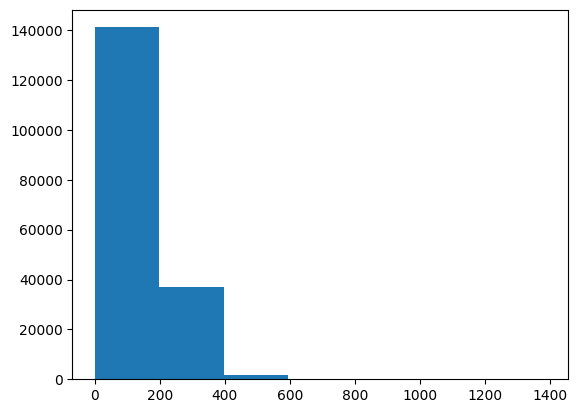

In [51]:
# Check the distribution of our sequences at character-level
# import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

Okay, looks like most of our sequences are between 0 and 200 characters long.

Let's use NumPy's percentile to figure out what length covers 95% of our sequences

In [52]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

> 🔑 **Note:** You can experiment here to figure out what the optimal `output_sequence_length` should be, perhaps using the mean results in as good results as using the 95% percentile.

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [53]:
# Get all keyboard characters for char-level embedding
# import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [54]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV(Out Of Vocab, '[UNK]') token
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=output_seq_char_len,
                                                    standardize="lower_and_strip_punctuation", # por default já é!!
                                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

Nice! Now we've adapted our `char_vectorizer` to our character-level sequences, let's check out some characteristics about it using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization#get_vocabulary) method.

In [55]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [56]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c u r r e n t l y   l i t t l e   i s   k n o w n   a b o u t   t h e   c l i n i c a l   a n d   r e s o u r c e   i m p l i c a t i o n s   o f   i m p l e m e n t i n g   c c b t   w i t h i n   t h e   n a t i o n a l   h e a l t h   s e r v i c e   f o r   a d o l e s c e n t s   w i t h   l o w   m o o d / d e p r e s s i o n   .

Length of chars: 146

Vectorized chars:
[[11 16  8  8  2  6  3 12 19 12  4  3  3 12  2  4  9 23  6  7 20  6  5 22
   7 16  3  3 13  2 11 12  4  6  4 11  5 12  5  6 10  8  2  9  7 16  8 11
   2  4 15 14 12  4 11  5  3  4  7  6  9  7 17  4 15 14 12  2 15  2  6  3
   4  6 18 11 11 22  3 20  4  3 13  4  6  3 13  2  6  5  3  4  7  6  5 12
  13  2  5 12  3 13  9  2  8 21  4 11  2 17  7  8  5 10  7 12  2  9 11  2
   6  3  9 20  4  3 13 12  7 20 15  7  7 10 10  2 14  8  2  9  9  4  7  6
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

You'll notice sequences with a length shorter than 290 (`output_seq_char_length`) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the `standardize` parameter of `TextVectorization` being `"lower_and_strip_punctuation"` and the `split` parameter being `"whitespace"` by default, symbols (such as `@`) and spaces are removed.

> 🔑 **Note:** If you didn't want punctuation to be removed (keep the `@`, `%` etc), you can create a custom standardization callable and pass it as the `standardize` parameter. See the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer documentation for more.


# Creating a character-level embedding

We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the [`tensorflow.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) class.

Our character-level embedding layer requires an input dimension and output dimension.

The input dimension (`input_dim`) will be equal to the number of different characters in our `char_vocab` (28). And since we're following the structure of the model in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), the output dimension of the character embedding (`output_dim`) will be 25.

In [57]:
# Create char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                       output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                                       mask_zero=False,  # don't use masks (this messes up model_5 if set to True)
                                       name='char_embed')

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
c u r r e n t l y   l i t t l e   i s   k n o w n   a b o u t   t h e   c l i n i c a l   a n d   r e s o u r c e   i m p l i c a t i o n s   o f   i m p l e m e n t i n g   c c b t   w i t h i n   t h e   n a t i o n a l   h e a l t h   s e r v i c e   f o r   a d o l e s c e n t s   w i t h   l o w   m o o d / d e p r e s s i o n   .

Embedded chars (after vectorization and embedding):
[[[-0.04112165 -0.03558288  0.00808138 ...  0.03823966  0.0173024
    0.02344077]
  [ 0.03198707  0.02504731  0.01512745 ... -0.01453357 -0.04539453
    0.01889695]
  [ 0.03907445 -0.04434018  0.03428329 ... -0.02438302 -0.03784777
    0.04720454]
  ...
  [ 0.00096826  0.02728707  0.04111603 ... -0.02501459  0.0497306
    0.01128137]
  [ 0.00096826  0.02728707  0.04111603 ... -0.02501459  0.0497306
    0.01128137]
  [ 0.00096826  0.02728707  0.04111603 ... -0.02501459  0.0497306
    0.01128137]]]

Character embedding shape: (1, 290, 25)


Wonderful! Each of the characters in our sequences gets turned into a 25 dimension embedding.

# Building a Conv1D model to fit on character embeddings

Now we've got a way to turn our character-level sequences into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (`model_1`) except it'll take character-level sequences as input instead of token-level sequences.

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

In [58]:
# Make Conv1D on chars only
inputs = tf.keras.layers.Input(shape=(1,), dtype='string', name='input_layer')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_conv1D_char_embedding")

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [59]:
# Check the summary of conv1d_char_model
model_2.summary()

Model: "model_2_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset`'s.

In [60]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [61]:
# Fit the model on chars only
model_3_history = model_2.fit(train_char_dataset,
                              steps_per_epoch=int(0.7 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.7 * len(val_char_dataset)))

Epoch 1/3
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5656 - loss: 1.0838 - val_accuracy: 0.6914 - val_loss: 0.8037
Epoch 2/3
1689/3938 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6936 - loss: 0.8002

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3938/3938 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6938 - loss: 0.7969 - val_accuracy: 0.6938 - val_loss: 0.8009
Epoch 3/3
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7073 - loss: 0.7707 - val_accuracy: 0.7231 - val_loss: 0.7315


In [62]:
# Evaluate model_2 on whole validation char dataset
model_2.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7221 - loss: 0.7334


[0.7365989685058594, 0.7213358879089355]

In [63]:
# Make predictions with character model only
model_2_pred_probs = model_2.predict(val_char_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.23582868, 0.42988265, 0.02156916, 0.2836949 , 0.02902465],
       [0.29182154, 0.5900755 , 0.0011614 , 0.11530135, 0.00164019],
       [0.06842256, 0.17890385, 0.01102364, 0.72875565, 0.01289424],
       ...,
       [0.01877672, 0.01925328, 0.03359121, 0.01663998, 0.9117388 ],
       [0.05328505, 0.16107443, 0.22634211, 0.08673789, 0.47256058],
       [0.24460761, 0.7151124 , 0.02802391, 0.00957389, 0.00268215]],
      dtype=float32)

In [64]:
# Convert predictions to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [65]:
# Calculate Conv1D char only model results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_2_preds)
model_2_results

{'accuracy': 72.133589302264,
 'precision': 0.7294165724487346,
 'recall': 0.72133589302264,
 'f1': 0.7223639604532184}

# Model 3: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:
1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_2` with a slight modification to reflect the paper)
3. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

> ⚛: We use [] as the input shape when we are using pre-trained embeddings and (1,) with custom embeddings.

In [66]:
# Use a pipeline as a high-level helper
from transformers import pipeline
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

pipe = pipeline("token-classification", model="w11wo/indonesian-roberta-base-posp-tagger")

tokenizer = AutoTokenizer.from_pretrained("w11wo/indonesian-roberta-base-posp-tagger")
model = AutoModelForTokenClassification.from_pretrained("w11wo/indonesian-roberta-base-posp-tagger")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.70k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [67]:
model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

class MyLayer(tf.keras.Layer):
    def call(self, x):
        return model(x)

In [68]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embedding = MyLayer()(token_inputs)
token_output_dense = tf.keras.layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output_dense)

# 2. Setup char inputs/model
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=output_seq_char_len,
                                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = tf.keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                            output_dim=25, # set size of embedding vector,
                                            name="char_embedding")(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3.Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer,
                         name="model_3_token_and_char_embeddings")

In [69]:
print(len(rct_20k_text_vocab))

64841


Woah... There's a lot going on here, let's get a summary and plot our model to visualize what's happening.

In [70]:
model_3.summary()

Model: "model_3_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ my_layer (MyLayer)        │ (None, 512)            │              0 │ token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, 290, 25)        │          1,750 │ char_vectorizer[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         65,664 │ my_layer[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         10,200 │ char_embedding[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ dense[0][0],           │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 200)            │         35,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 5)              │          1,005 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 114,419 (446.95 KB)

 Trainable params: 114,419 (446.95 KB)

 Non-trainable params: 0 (0.00 B)

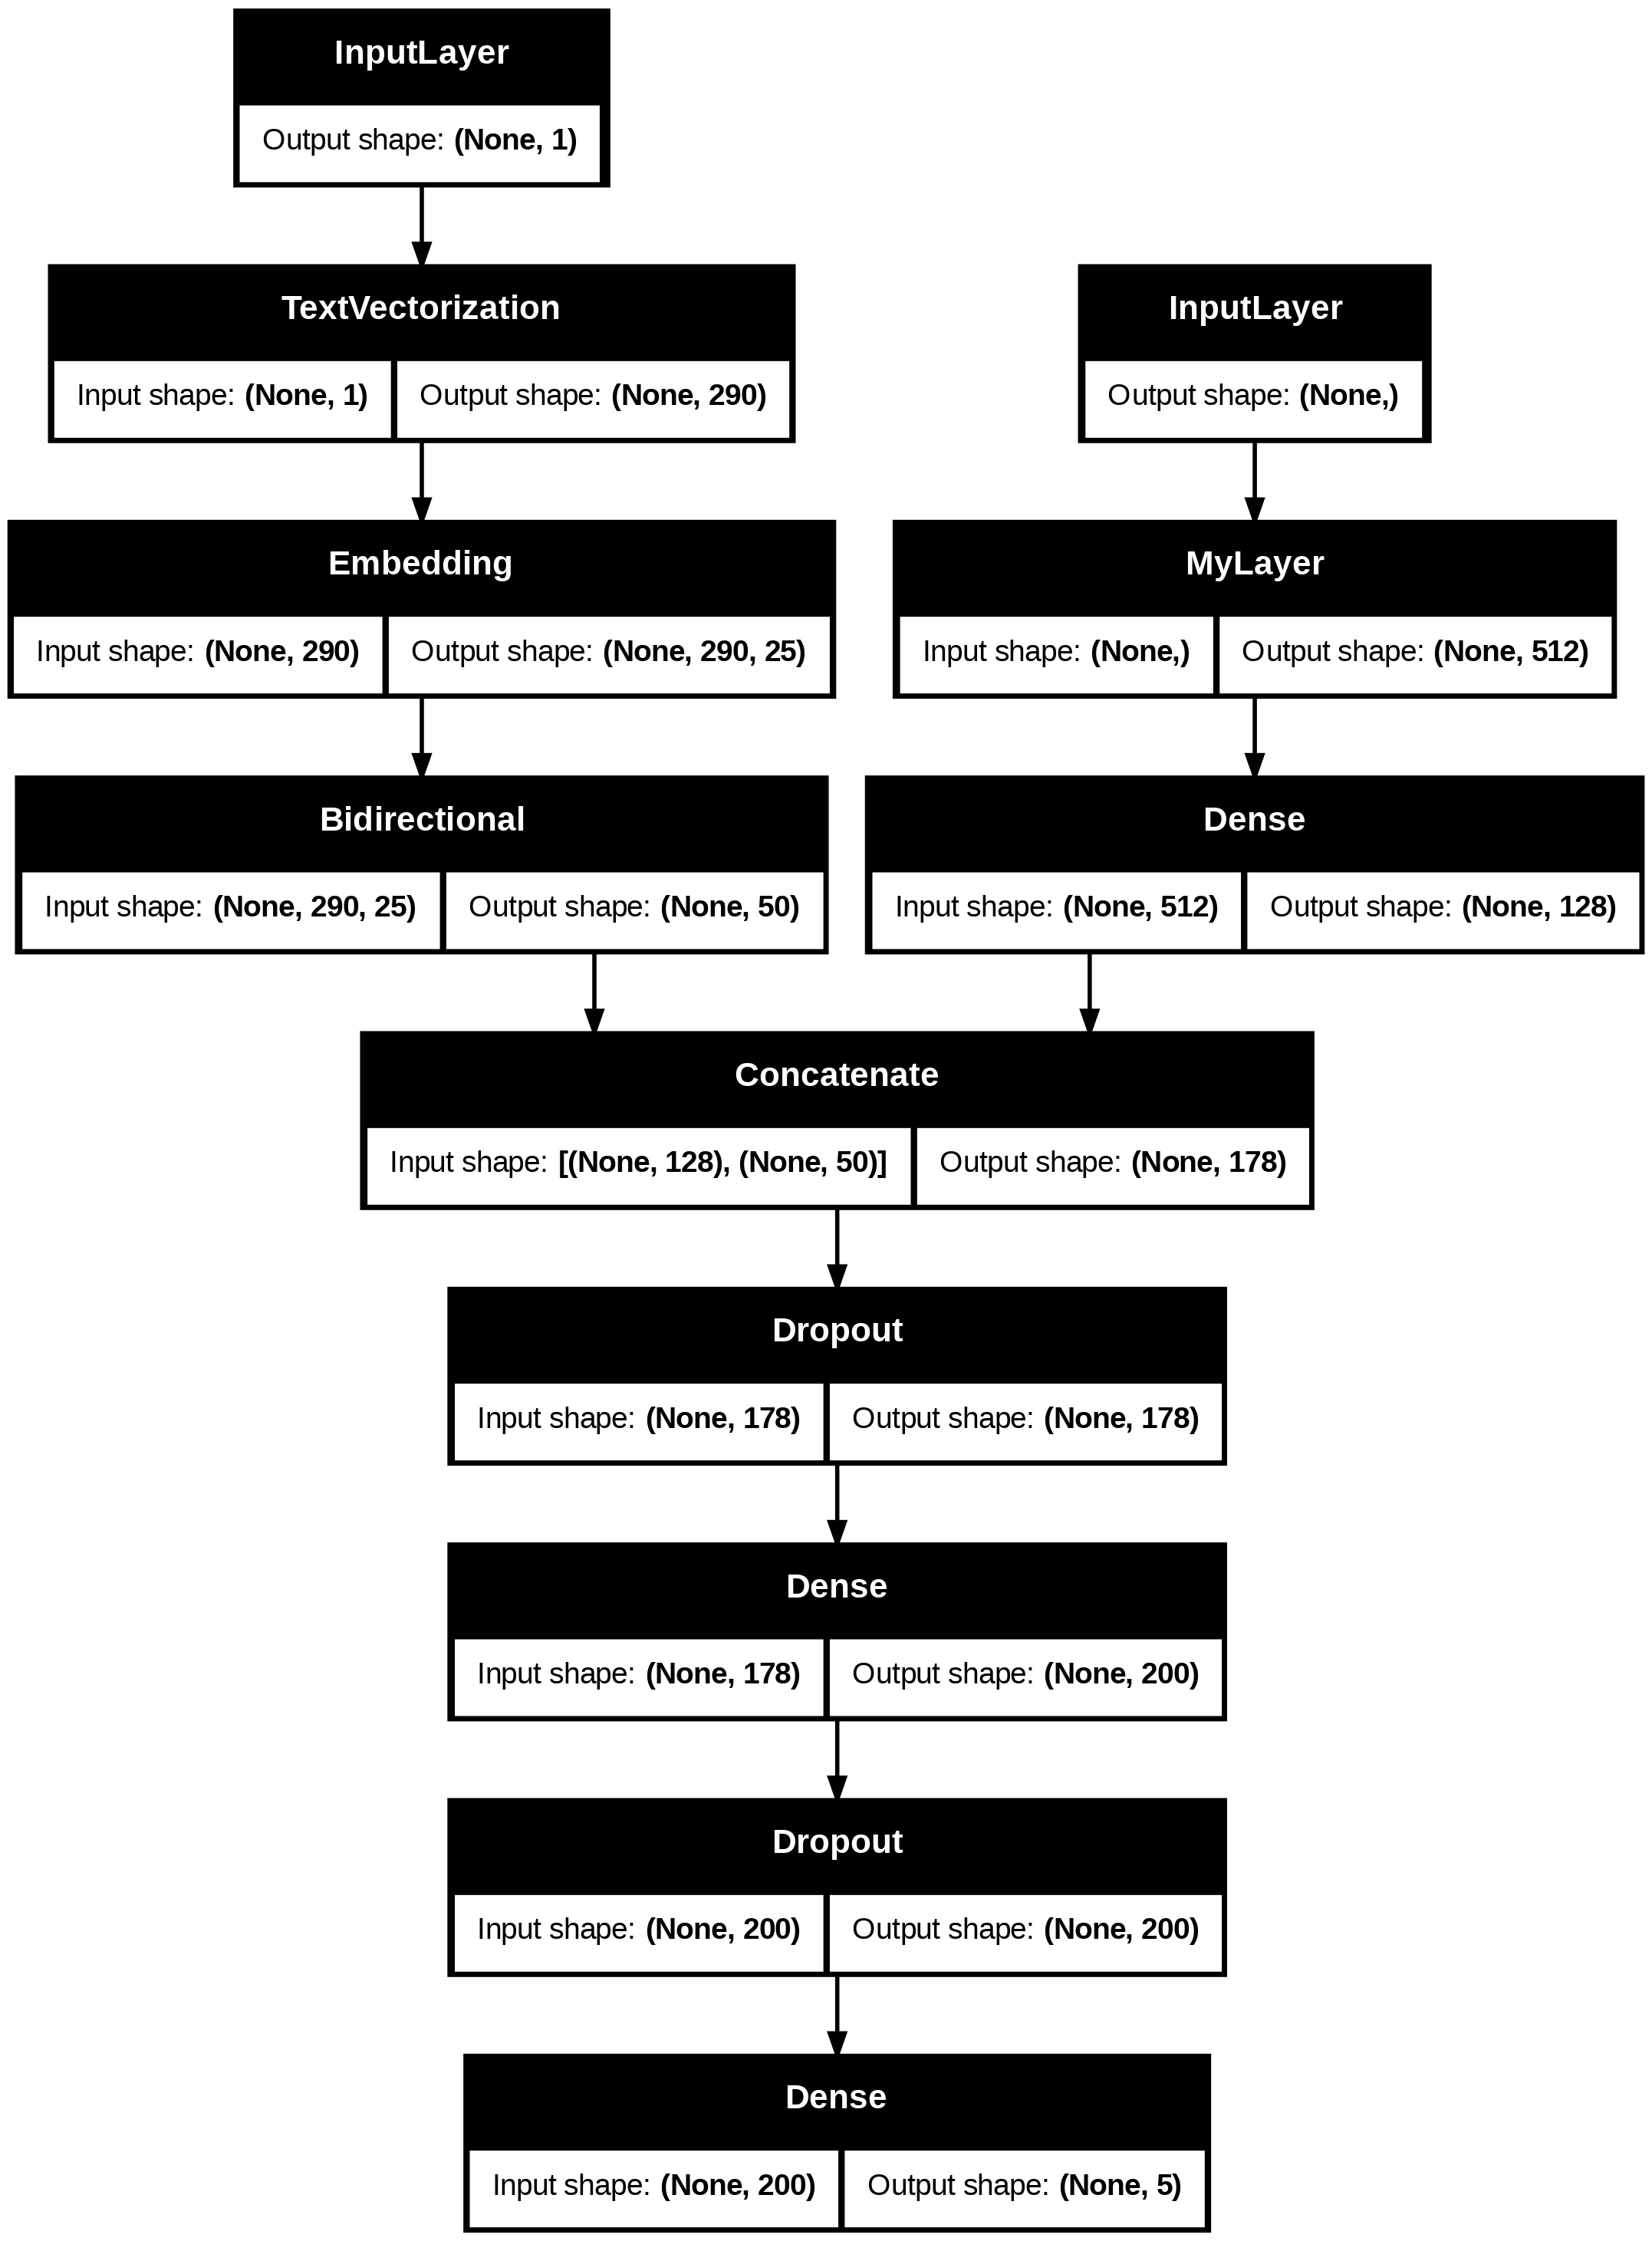

In [71]:
# Plot hybrid token and character model
# from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model_3, show_shapes=True)

Now that's a good looking model. Let's compile it just as we have the rest of our models.

> 🔑 **Note:** Section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) mentions using the SGD (stochastic gradient descent) optimizer, however, to stay consistent with our other models, we're going to use the Adam optimizer. As an exercise, you could try using [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) instead of [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) and compare the results.

In [72]:
# Compile token char model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:
* `((token_data, char_data), (label))`

Let's see it in action.

# Combining token and character data into a `tf.data` dataset

In [73]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [74]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

# Fitting a model on token and character-level sequences

In [75]:
# Fit the model on tokens and chars
model_3_history = model_3.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.3452 - loss: 1.5324 - val_accuracy: 0.3890 - val_loss: 1.4555
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.3974 - loss: 1.4512 - val_accuracy: 0.4973 - val_loss: 1.4067
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4378 - loss: 1.4217 - val_accuracy: 0.5143 - val_loss: 1.3604


In [76]:
# Evaluate on the whole validation dataset
model_3.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5109 - loss: 1.3567


[1.3552277088165283, 0.5152919292449951]

Nice! Our token-character hybrid model has come to life!

To make predictions with it, since it takes multiplie inputs, we can pass the `predict()` method a tuple of token-level sequences and character-level sequences.

We can then evaluate the predictions as we've done before.

In [77]:
# Make predictions using the token-character model hybrid
model_3_pred_probs = model_3.predict(val_char_token_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


array([[0.12446547, 0.16250446, 0.30157074, 0.08476885, 0.3266905 ],
       [0.1330568 , 0.16411921, 0.3625496 , 0.08300596, 0.25726837],
       [0.11883375, 0.16347463, 0.32791102, 0.08259262, 0.30718797],
       ...,
       [0.10175171, 0.13265905, 0.29199257, 0.07554012, 0.3980565 ],
       [0.11264127, 0.14717679, 0.32363576, 0.08045375, 0.3360924 ],
       [0.11658216, 0.14892627, 0.34060428, 0.08210984, 0.3117775 ]],
      dtype=float32)

In [78]:
# Turn prediction probabilities into prediction classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 2, 2, ..., 4, 4, 2])>

In [79]:
# Get results of token-char-hybrid model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 51.52919369786839,
 'precision': 0.34377716946193276,
 'recall': 0.5152919369786839,
 'f1': 0.41067997361794445}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

It seems like combining token embeddings and character embeddings gave our model a little performance boost(No, it didn't).

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

Abstracts typically come in a sequential order, such as:
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...

Or

* `BACKGROUND` ...
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...
* `CONCLUSIONS` ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,
* `Sentence 1 of 10` ...
* `Sentence 2 of 10` ...
* `Sentence 3 of 10` ...
* `Sentence 4 of 10` ...
* ...


You might've noticed this when we created our `preprocess_text_with_line_numbers()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [80]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

![example of engineering features into our dataset to help our model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-engineered-features-at-test-time.png)
*Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be available at test time (we can just count the number of sentences in an abstract and the number of each one).*

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

> 🛠 **Exercise:** Another way of creating our positional embedding feature would be to combine the `"line_number"` and `"total_lines"` columns into one, for example a `"line_position"` column may contain values like `1_of_11`, `2_of_11`, etc. Where `1_of_11` would be the first line in an abstract 11 sentences long. After going through the following steps, you might want to revisit this positional embedding stage and see how a combined column of `"line_position"` goes against two separate columns.

# Create positional embeddings

Okay, enough talk about positional embeddings, let's create them.

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To do this, we can use the [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) utility.

`tf.one_hot` returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the `depth` parameter determines the dimension of the returned tensor.

To figure out what we should set the `depth` parameter to, let's investigate the distribution of the `"line_number"` column.

> 🔑 **Note:** When it comes to one-hot-encoding our features, Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class is another viable option here.

In [98]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [81]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

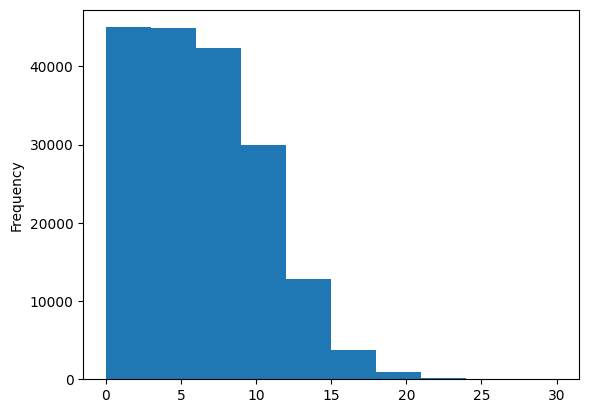

In [82]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the `"line_number"` column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the `depth` parameter of `tf.one_hot` to 15.

In [83]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Setting the `depth` parameter of `tf.one_hot` to 15 means any sample with a `"line_number"` value of over 15 gets set to a tensor of all 0's, where as any sample with a `"line_number"` of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the `"line_number"` value.

> 🔑 **Note:** We could create a one-hot tensor which has room for all of the potential values of `"line_number"` (`depth=30`), however, this would end up in a tensor of double the size of our current one (`depth=15`) where the vast majority of values are 0. Plus, only ~2,000/180,000 samples have a `"line_number"` value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the **curse of dimensionality**. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the `depth` parameter as an extension.

In [84]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

We can do the same as we've done for our `"line_number"` column witht he `"total_lines"` column. First, let's find an appropriate value for the `depth` parameter of `tf.one_hot`.

In [85]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


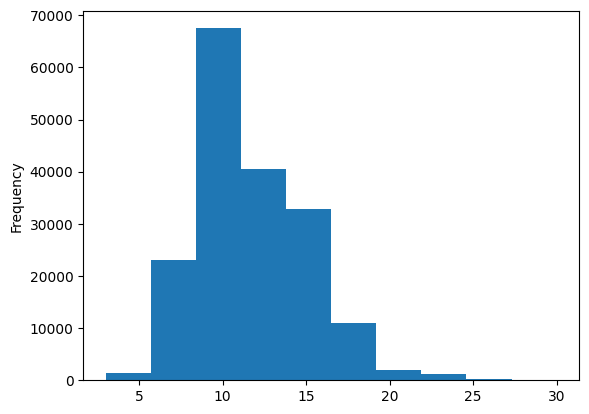

In [86]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

Looking at the distribution of our `"total_lines"` column, a value of 20 looks like it covers the majority of samples.

We can confirm this with [`np.percentile()`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html).

In [87]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [88]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

# Building a tribrid embedding model

Woohoo! Positional embedding tensors ready.

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We'll be venturing into uncovered territory but there will be nothing here you haven't practiced before.

More specifically we're going to go through the following steps:

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Create a `"line_number"` model (takes in one-hot-encoded `"line_number"` tensor and passes it through a non-linear layer)
4. Create a `"total_lines"` model (takes in one-hot-encoded `"total_lines"` tensor and passes it through a non-linear layer)
5. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
6. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

Woah! That's alot... but nothing we're not capable of. Let's code it.

In [89]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = MyLayer()(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu', name='token_outputs')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32), name='bi_layer')(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = tf.keras.layers.Dense(32, activation='relu', name='dense_layer_line_numbers')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype='int32', name='total_lines_inputs')
y = tf.keras.layers.Dense(32, activation='relu', name='dense_layer_total_lines')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])


z = tf.keras.layers.Dense(256, activation='relu', name='z_layer')(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = tf.keras.layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output, total_line_model.output, z])

# 7. Create output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(z)

# 8. Put together model
model_4 = tf.keras.Model(inputs=[line_number_model.input, total_line_model.input,
                                 token_model.input, char_model.input],
                         outputs=output_layer, name='tribrid_embedding_model')

In [90]:
# Get a summary of our token, char and positional embedding model
model_4.summary()

Model: "tribrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ my_layer_1 (MyLayer)      │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,750 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_outputs (Dense)     │ (None, 128)            │         65,664 │ my_layer_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_layer (Bidirectional)  │ (None, 64)             │         14,848 │ char_embed[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 192)            │              0 │ token_outputs[0][0],   │
│ (Concatenate)             │                        │                │ bi_layer[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_inputs        │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_layer (Dense)           │ (None, 256)            │         49,408 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_layer_line_numbers  │ (None, 32)             │            512 │ line_number_input[0][… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_layer_total_lines   │ (None, 32)             │            672 │ total_lines_inputs[0]… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ z_layer[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_positional_em… │ (None, 320)            │              0 │ dense_layer_line_numb… │
│ (Concatenate)             │                        │                │ dense_layer_total_lin… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense) 

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

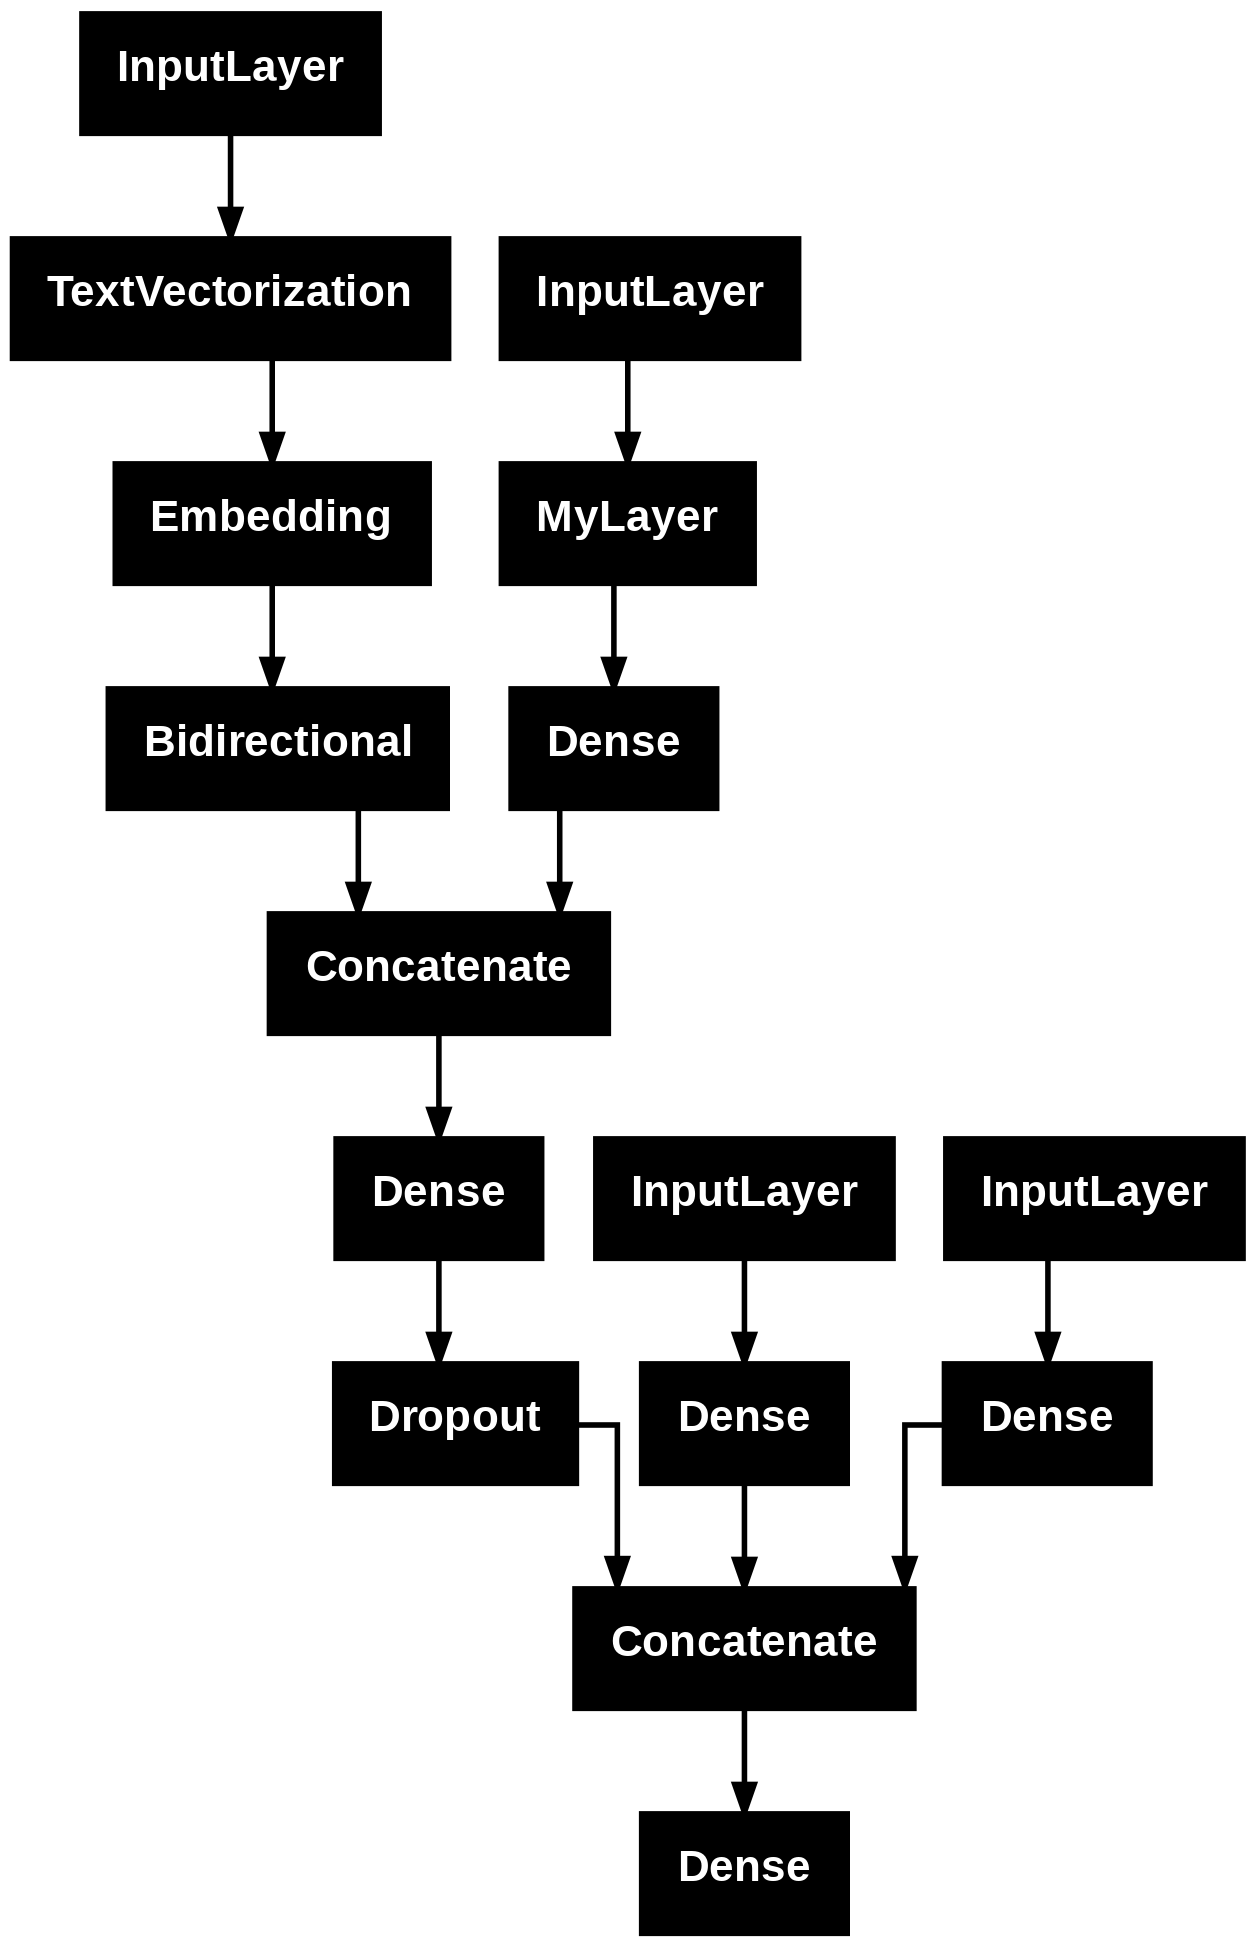

In [91]:
tf.keras.utils.plot_model(model_4)

Visualizing the model makes it much easier to understand.

Essentially what we're doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

You'll notice our model is looking very similar to the model shown in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf). However, a few differences still remain:
* We're using pretrained TensorFlow Hub token embeddings instead of GloVe emebddings.
* We're using a Dense layer on top of our token-character hybrid embeddings instead of a bi-LSTM layer.
* Section 3.1.3 of the paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order) but it isn't shown in Figure 1. To makeup for the lack of this layer in our model, we've created the positional embeddings layers.
* Section 4.2 of the paper mentions the token and character embeddings are updated during training, our pretrained TensorFlow Hub embeddings remain frozen.
* The paper uses the [`SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) optimizer, we're going to stick with [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

All of the differences above are potential extensions of this project.

Now our model is constructed, let's compile it.

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:
* `[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:
* `[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.

> 📖 **Resource:** For more on label smoothing, see the great blog post by PyImageSearch, [*Label smoothing with Keras, TensorFlow, and Deep Learning*](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).

In [92]:
# Compile token, char, positional embedding model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Create tribrid embedding datasets and fit tribrid model

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset`'s.

In [93]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [94]:
# Fit the token, char and positional embedding model
history_model_4 = model_4.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.7 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.7 * len(val_pos_char_token_dataset)))

Epoch 1/3
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 114s 28ms/step - accuracy: 0.7652 - loss: 1.0332 - val_accuracy: 0.8464 - val_loss: 0.9165
Epoch 2/3
1688/3938 ━━━━━━━━━━━━━━━━━━━━ 57s 26ms/step - accuracy: 0.8418 - loss: 0.9244

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3938/3938 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.8430 - loss: 0.9241 - val_accuracy: 0.8445 - val_loss: 0.9137
Epoch 3/3
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 112s 28ms/step - accuracy: 0.8499 - loss: 0.9145 - val_accuracy: 0.8540 - val_loss: 0.9034


Tribrid model trained! Time to make some predictions with it and evaluate them just as we've done before.

In [95]:
# Make predictions with token-char-positional hybrid model
model_4_pred_probs = model_4.predict(val_pos_char_token_dataset, verbose=1)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


array([[0.6427579 , 0.09736363, 0.00866343, 0.23278344, 0.01843164],
       [0.65774083, 0.09934647, 0.04819423, 0.1843339 , 0.01038452],
       [0.4672658 , 0.09028802, 0.04797478, 0.35329172, 0.04117974],
       ...,
       [0.03138778, 0.09865972, 0.02360642, 0.03325265, 0.8130935 ],
       [0.02350441, 0.43583542, 0.04316537, 0.02452238, 0.47297245],
       [0.0593139 , 0.89191055, 0.01834436, 0.02033488, 0.01009633]],
      dtype=float32)

In [96]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [97]:
# Calculate results of token-char-positional hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 85.22110419700782,
 'precision': 0.8581728079556076,
 'recall': 0.8522110419700781,
 'f1': 0.8492685793005159}

# Compare model results